In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import sys
ROOT = "../../"
sys.path.append(ROOT) # Add root directory to path

from src.utils.ClassifierModel import ClassifierModel
from src.utils.REPDataset import REPDataset
from src.utils.perturbations import *

import torchvision.datasets as datasets
from torchvision.transforms import ToTensor

from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier
from torchvision import datasets, transforms

In [2]:
# Step 1: Load the CIFAR-10 dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

x_train = trainset.data / 255.0  # Scale pixel values to [0, 1]
y_train = np.array(trainset.targets)
x_test = testset.data / 255.0  # Scale pixel values to [0, 1]
y_test = np.array(testset.targets)

x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)

y_train = np.eye(10)[y_train].astype(np.float32)
y_test = np.eye(10)[y_test].astype(np.float32)

min_pixel_value = 0.0
max_pixel_value = 1.0

Files already downloaded and verified
Files already downloaded and verified


In [3]:
x_train[0].shape

(3, 32, 32)

In [9]:
def plot_perturbation_layers(dataset, perturbations, idx):
    """Plots each layer of perturbation for a given instance from the REPDataset.

    Args:
        dataset (REPDataset): The REPDataset instance.
        idx (int): The index of the instance to plot.
    """
    # Get the perturbed data and label for the specified index
    perturbed_data, label = dataset[idx]
    
    # Get the number of perturbation layers
    num_layers = perturbed_data.size(0)
    
    # Create a grid of subplots
    num_cols = 4
    num_rows = (num_layers + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 3*num_rows))
    
    # Flatten the axes array for easier indexing
    axes = axes.flatten()
    
    # Plot each layer of perturbation
    for i in range(num_layers):
        layer_data = perturbed_data[i].squeeze().permute(1, 2, 0).cpu().numpy()
        layer_data = (layer_data - layer_data.min()) / (layer_data.max() - layer_data.min())
        axes[i].imshow(layer_data, cmap='gray')
        axes[i].set_title(f"{perturbations[i]}")
        axes[i].axis('off')
    
    # Remove any unused subplots
    for i in range(num_layers, len(axes)):
        fig.delaxes(axes[i])
    
    fig.suptitle("Visualization of Different Perturbations")

    # Adjust the spacing between subplots
    plt.tight_layout()
    
    # Show the plot
    plt.show()

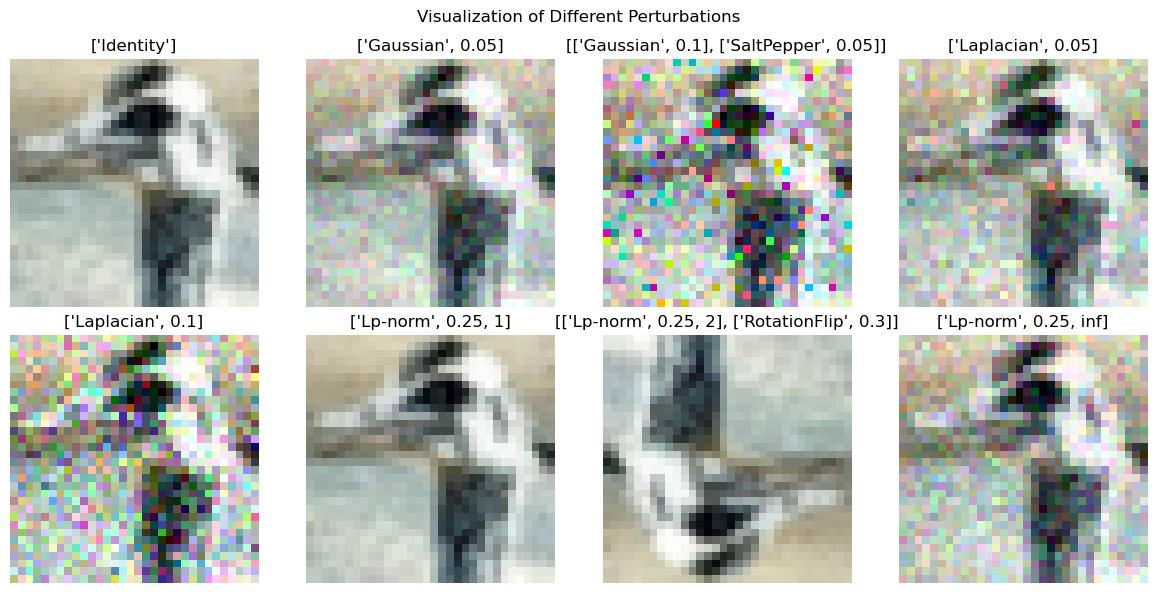

In [11]:
# Define the perturbation functions
perturbation_description = [["Identity"],
                            ["Gaussian", 0.05],
                            [["Gaussian", 0.1],["SaltPepper", 0.05]],
                            ["Laplacian", 0.05],
                            ["Laplacian", 0.1],
                            ["Lp-norm", 0.25, 1],
                            [["Lp-norm", 0.25, 2],["RotationFlip", 0.3]],
                            ["Lp-norm", 0.25, float('inf')]]

perturbations = create_perturbations(perturbation_description)

shuffle = False
include_original = False
train_val_split = 0.85
test_split = 0

rep_trainset = REPDataset(data=x_train, labels=y_train, split=train_val_split, 
                          perturbations=perturbations, include_original=include_original, 
                          shuffle=shuffle, class_names=["0"])
rep_testset = REPDataset(x_test, y_test, test_split,
                         perturbations, include_original, shuffle, class_names=["0"])

np.random.seed(None)
plot_perturbation_layers(rep_trainset, perturbation_description, int(np.random.rand()*len(x_train)))

In [6]:
# configuration parameters, you can play around with these
pooling = 'max' # 'max' or 'mean'

if pooling == 'max':
    pool_fcn = nn.AdaptiveMaxPool2d((1, 1))
else:
    pool_fcn = nn.AdaptiveAvgPool2d((1, 1))

# your model will have length(channel_widths)-1 layers
channel_widths = [1, 16, 32, 64, 32] # must start with a 1 and be at least length--2
linear_sizes = [64, 32]
kernel = 3
model = ClassifierModel(channel_widths, linear_sizes, kernel, pool_fcn, num_perturbations=rep_trainset.multiplicity, num_classes=10)

In [7]:
config = {'lr': 1e-3,
          'n_epochs': 5,
          'batch_size': 64}
verbose = True # print metrics during training, False for no printing
model.train_model(rep_trainset, config)

RuntimeError: Expected floating point type for target with class probabilities, got Long

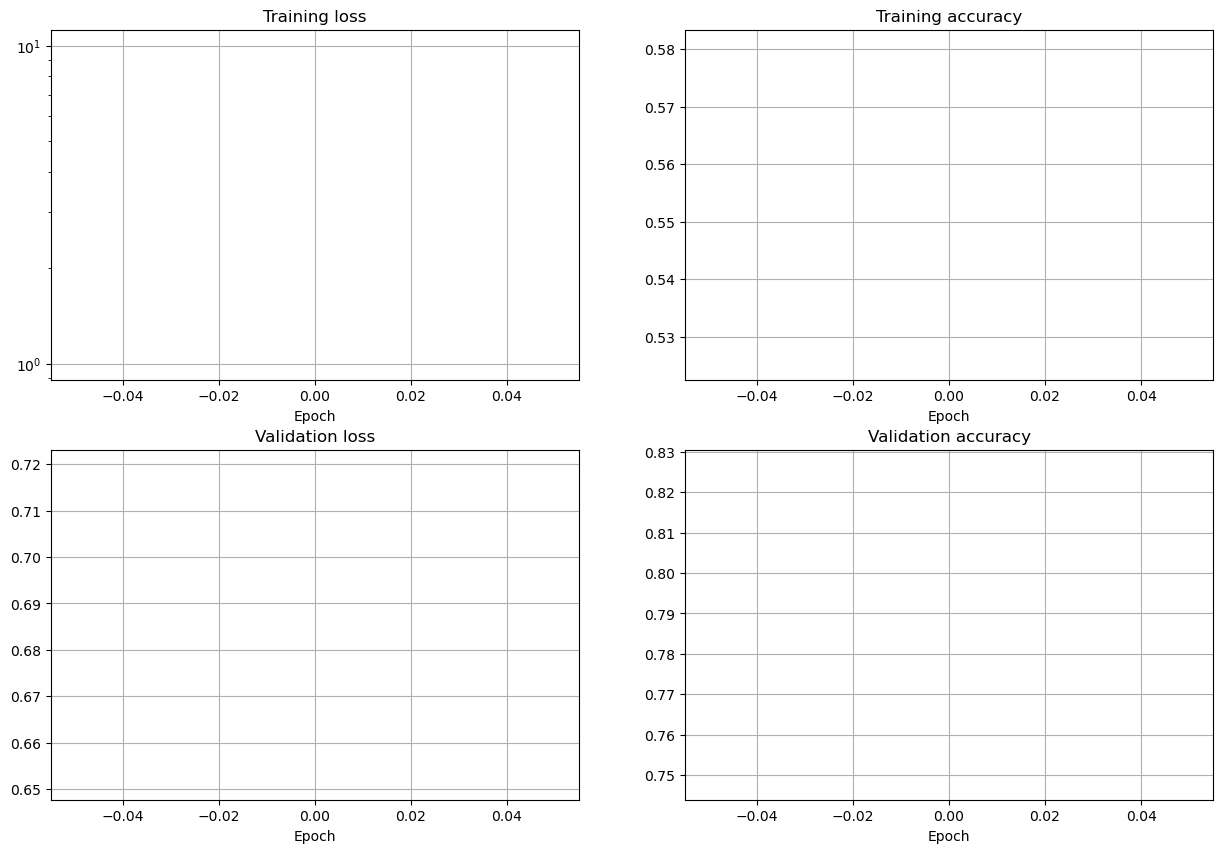

In [7]:
# plot training/validation loss and accuracy over training time
model.plot_model_results()

In [21]:
model_name = 'no_perturbations_01'
model.save_model(ROOT + 'src/models/' + model_name + '.pt')